In [2]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable

from joblib import Parallel, delayed

warnings.filterwarnings('ignore')


In [3]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [4]:
def preprocess_h0(ds):
    
  
    keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
                'PHIS','USTAR','QT','GCLDLWP',
                'THETAL','CDNUMC','CLDBOT','CLDLOW',
                'CLDMED','CLDTOP','CLDTOT','THLP2_CLUBB','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
                'RCM_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','UP2_CLUBB','UPWP_CLUBB',
                'VP2_CLUBB','T','Q','OMEGA','PBLH','U','V','WP2_CLUBB','WP3_CLUBB','WPRCP_CLUBB',
                'WPRTP_CLUBB',
                'WPTHLP_CLUBB','WPTHVP_CLUBB','Z3','PRECT','PRECC',
                'TGCLDCWP','TGCLDLWP','GCLDLWP',
                'LHFLX','SHFLX','TREFHT','RHREFHT']
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
    dsSel      = ds[keepVars]
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    dsSel = dsSel.load()

    return dsSel

## Read in data

**Round 1: Initialize from a spun-up SGP initial condition in early summer**

In [5]:
# caseDir = '/project/amp/mdfowler/cases/FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFalse_setSfcFlxFALSE_clmInit_Urban33Lake33Grass34.LASSO_20150501/run/'
# caseDir = '/project/amp/mdfowler/cases/FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFalse_setSfcFlxFALSE_clmInit_Urban40Lake50Grass10.LASSO_20150501/run/'
caseDir = '/project/amp/mdfowler/cases/FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFalse_setSfcFlxFALSE_clmInit_Urban25Lake25Grass25irrigcrop25.LASSO_20150501/run/'

## Get list of files 
listFiles_h0 = np.sort(glob.glob(caseDir+'atm/hist/*cam.h0*'))

listFilesCLM_h1 = np.sort(glob.glob(caseDir+'lnd/hist/*clm2.h1*'))
listFilesCLM_h0 = np.sort(glob.glob(caseDir+'lnd/hist/*clm2.h0*'))        

case_h0_rnd1 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h0 files loaded')

caseCLM_h0_rnd1 = xr.open_mfdataset(listFilesCLM_h0, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('CLM_h0 files loaded with mfdataset')

caseCLM_h1_rnd1 = xr.open_mfdataset(listFilesCLM_h1, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('CLM_h1 files loaded with mfdataset')

## Assign a more helpful itme coordinate to clm datasets 
caseCLM_h0_rnd1['time'] = case_h0_rnd1['time']
caseCLM_h1_rnd1['time'] = case_h0_rnd1['time']


h0 files loaded
CLM_h0 files loaded with mfdataset
CLM_h1 files loaded with mfdataset


**Round 2: Initialize from end of run 1 (Sept 28)**

In [8]:
caseDir = '/project/amp/mdfowler/cases/FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFalse_setSfcFlxFALSE_clmInit_Urban33Lake33Grass34_initXtrmeRndOne0928.LASSO_20150501_getRests/run/'
# caseDir = '/project/amp/mdfowler/cases/FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFalse_setSfcFlxFALSE_clmInit_Urban40Lake50Grass10_initXtrmeRndOne0928.LASSO_20150501_getRests/run/'

## Get list of files 
listFiles_h0 = np.sort(glob.glob(caseDir+'atm/hist/*cam.h0*'))

listFilesCLM_h1 = np.sort(glob.glob(caseDir+'lnd/hist/*clm2.h1*'))
listFilesCLM_h0 = np.sort(glob.glob(caseDir+'lnd/hist/*clm2.h0*'))        

case_h0_rnd2 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h0 files loaded')

caseCLM_h0_rnd2 = xr.open_mfdataset(listFilesCLM_h0, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('CLM_h0 files loaded with mfdataset')

caseCLM_h1_rnd2 = xr.open_mfdataset(listFilesCLM_h1, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('CLM_h1 files loaded with mfdataset')


## Assign a more helpful itme coordinate to clm datasets 
caseCLM_h0_rnd2['time'] = case_h0_rnd2['time']
caseCLM_h1_rnd2['time'] = case_h0_rnd2['time']


h0 files loaded
CLM_h0 files loaded with mfdataset
CLM_h1 files loaded with mfdataset


**Round 3: Initialize from early summer of Round 2 (06/15)**

In [45]:
caseDir = '/project/amp/mdfowler/cases/FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFalse_setSfcFlxFALSE_clmInit_Urban40Lake50Grass10_initXtrmeRndTwo0615.LASSO_20150501_getRests/run/'

## Get list of files 
listFiles_h0 = np.sort(glob.glob(caseDir+'atm/hist/*cam.h0*'))

listFilesCLM_h1 = np.sort(glob.glob(caseDir+'lnd/hist/*clm2.h1*'))
listFilesCLM_h0 = np.sort(glob.glob(caseDir+'lnd/hist/*clm2.h0*'))        

case_h0_rnd3 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h0 files loaded')

caseCLM_h0_rnd3 = xr.open_mfdataset(listFilesCLM_h0, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('CLM_h0 files loaded with mfdataset')

caseCLM_h1_rnd3 = xr.open_mfdataset(listFilesCLM_h1, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('CLM_h1 files loaded with mfdataset')

## Assign a more helpful itme coordinate to clm datasets 
caseCLM_h0_rnd3['time'] = case_h0_rnd3['time']
caseCLM_h1_rnd3['time'] = case_h0_rnd3['time']


h0 files loaded
CLM_h0 files loaded with mfdataset
CLM_h1 files loaded with mfdataset


**Round 4: Same as round 3, but initialized from *end* of round 2 (9/28)**

In [72]:
caseDir = '/project/amp/mdfowler/cases/FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFalse_setSfcFlxFALSE_clmInit_Urban40Lake50Grass10_initXtrmeRndTwo0928.LASSO_20150501_getRests/run/'

## Get list of files 
listFiles_h0 = np.sort(glob.glob(caseDir+'atm/hist/*cam.h0*'))

listFilesCLM_h1 = np.sort(glob.glob(caseDir+'lnd/hist/*clm2.h1*'))
listFilesCLM_h0 = np.sort(glob.glob(caseDir+'lnd/hist/*clm2.h0*'))        

case_h0_rnd4 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h0 files loaded')

caseCLM_h0_rnd4 = xr.open_mfdataset(listFilesCLM_h0, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('CLM_h0 files loaded with mfdataset')

caseCLM_h1_rnd4 = xr.open_mfdataset(listFilesCLM_h1, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('CLM_h1 files loaded with mfdataset')

## Assign a more helpful itme coordinate to clm datasets 
caseCLM_h0_rnd4['time'] = case_h0_rnd4['time']
caseCLM_h1_rnd4['time'] = case_h0_rnd4['time']


h0 files loaded
CLM_h0 files loaded with mfdataset
CLM_h1 files loaded with mfdataset


## Some analysis plots

In [79]:
np.shape(caseCLM_h0_rnd1.time.values)

(43489,)

(16556.000694444443, 16576.832291666666)

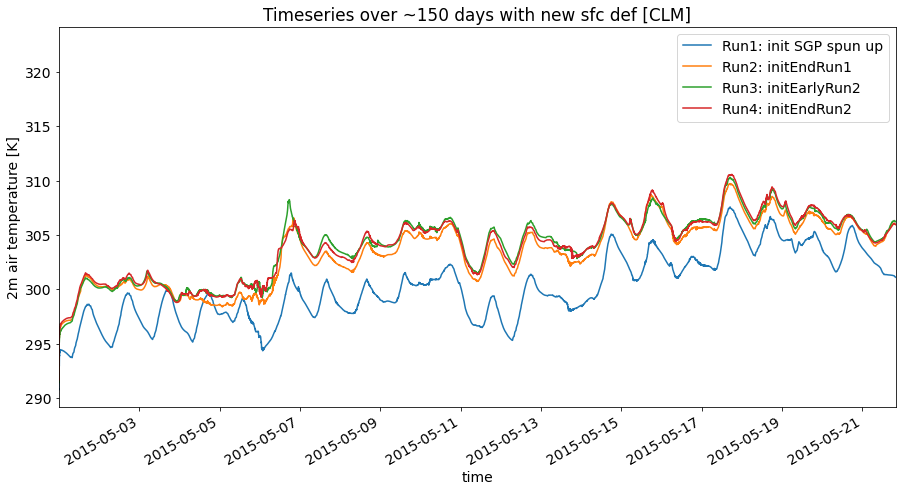

In [87]:
varPlot = 'TSA'

fig,axs = plt.subplots(1,1, figsize=(15,7))

caseCLM_h0_rnd1[varPlot].plot()
caseCLM_h0_rnd2[varPlot].plot()
caseCLM_h0_rnd3[varPlot].plot()
caseCLM_h0_rnd4[varPlot].plot()
plt.title('Timeseries over ~150 days with new sfc def [CLM]')
plt.rcParams.update({'font.size': 14})
plt.legend(['Run1: init SGP spun up','Run2: initEndRun1',
            'Run3: initEarlyRun2','Run4: initEndRun2'])

plt.xlim([caseCLM_h0_rnd1.time.values[0], caseCLM_h0_rnd1.time.values[6000]])


(16556.000694444443, 16576.832291666666)

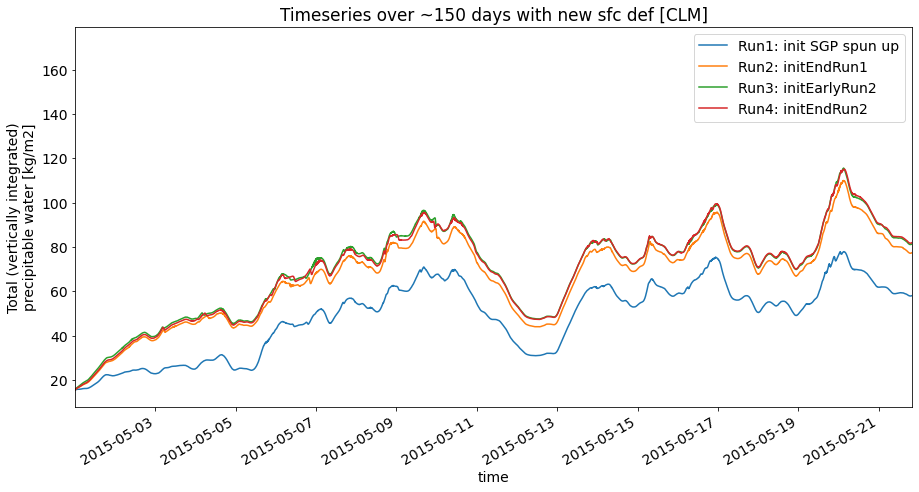

In [86]:
varPlot = 'TMQ'

fig,axs = plt.subplots(1,1, figsize=(15,7))

case_h0_rnd1[varPlot].plot()
case_h0_rnd2[varPlot].plot()
case_h0_rnd3[varPlot].plot()
case_h0_rnd4[varPlot].plot()
plt.title('Timeseries over ~150 days with new sfc def [CLM]')
plt.rcParams.update({'font.size': 14})
plt.legend(['Run1: init SGP spun up','Run2: initEndRun1',
            'Run3: initEarlyRun2','Run4: initEndRun2'])

plt.xlim([caseCLM_h0_rnd1.time.values[0], caseCLM_h0_rnd1.time.values[6000]])



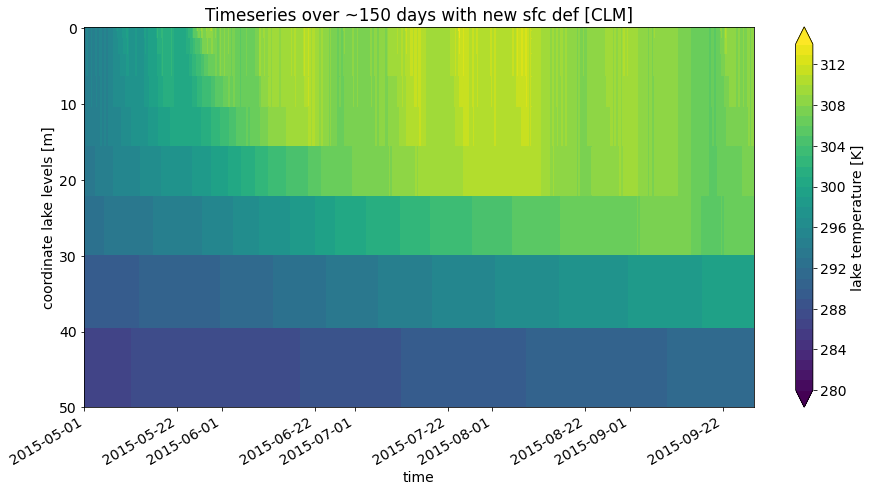

In [33]:
varPlot = 'TLAKE'

fig,axs = plt.subplots(1,1, figsize=(15,7))

caseCLM_h0_rnd1[varPlot].plot(x='time', levels=np.arange(280,315,1),extend='both')
plt.title('Timeseries over ~150 days with new sfc def [CLM]')
plt.rcParams.update({'font.size': 14})
axs.invert_yaxis()


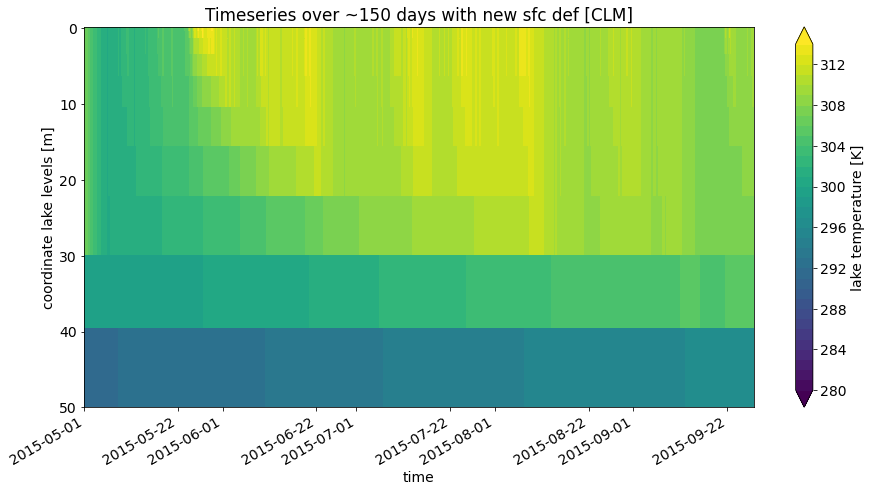

In [34]:
varPlot = 'TLAKE'

fig,axs = plt.subplots(1,1, figsize=(15,7))

# caseCLM_h0_rnd2[varPlot].plot(x='time', levels=np.arange(290,325,1),extend='both')
caseCLM_h0_rnd2[varPlot].plot(x='time', levels=np.arange(280,315,1),extend='both')
plt.title('Timeseries over ~150 days with new sfc def [CLM]')
plt.rcParams.update({'font.size': 14})
axs.invert_yaxis()
# axs.set_ylim([8,0])


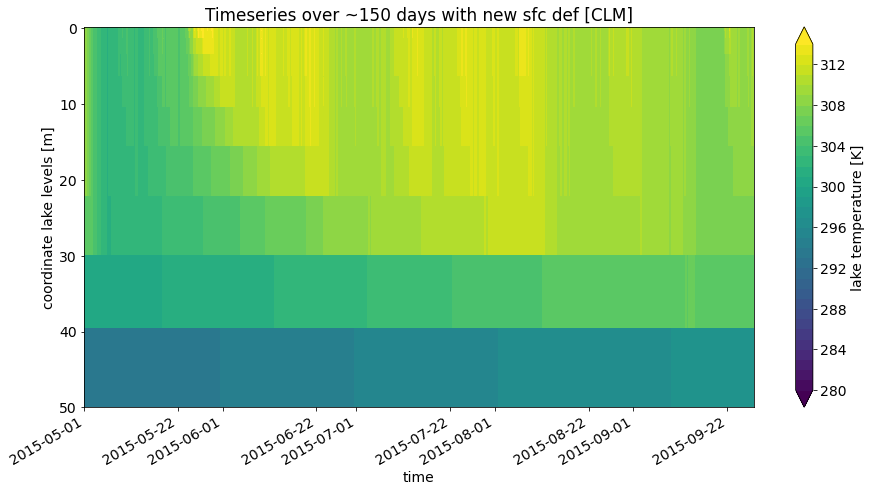

In [47]:
varPlot = 'TLAKE'

fig,axs = plt.subplots(1,1, figsize=(15,7))

# caseCLM_h0_rnd2[varPlot].plot(x='time', levels=np.arange(290,325,1),extend='both')
caseCLM_h0_rnd3[varPlot].plot(x='time', levels=np.arange(280,315,1),extend='both')
plt.title('Timeseries over ~150 days with new sfc def [CLM]')
plt.rcParams.update({'font.size': 14})
axs.invert_yaxis()
# axs.set_ylim([8,0])


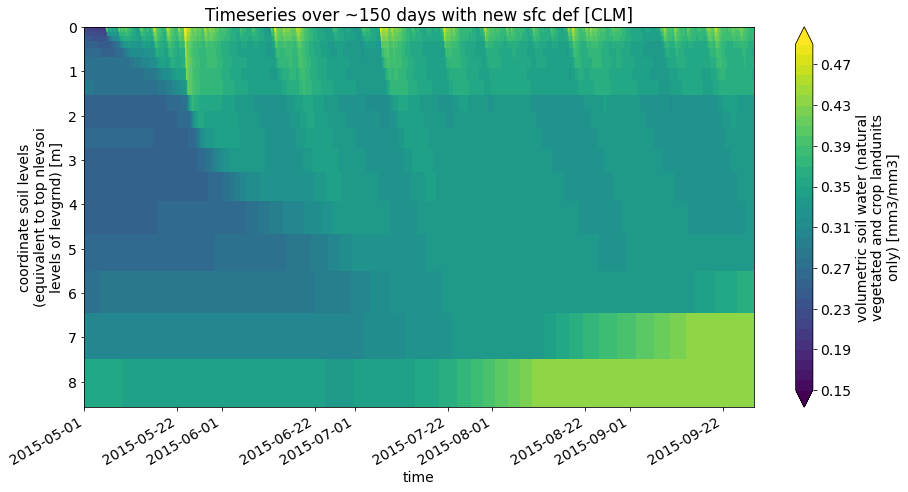

In [38]:
varPlot = 'H2OSOI'

fig,axs = plt.subplots(1,1, figsize=(15,7))

caseCLM_h0_rnd1[varPlot].plot(x='time',levels=np.arange(0.15,0.5,0.01),extend='both')
plt.title('Timeseries over ~150 days with new sfc def [CLM]')
plt.rcParams.update({'font.size': 14})
axs.invert_yaxis()


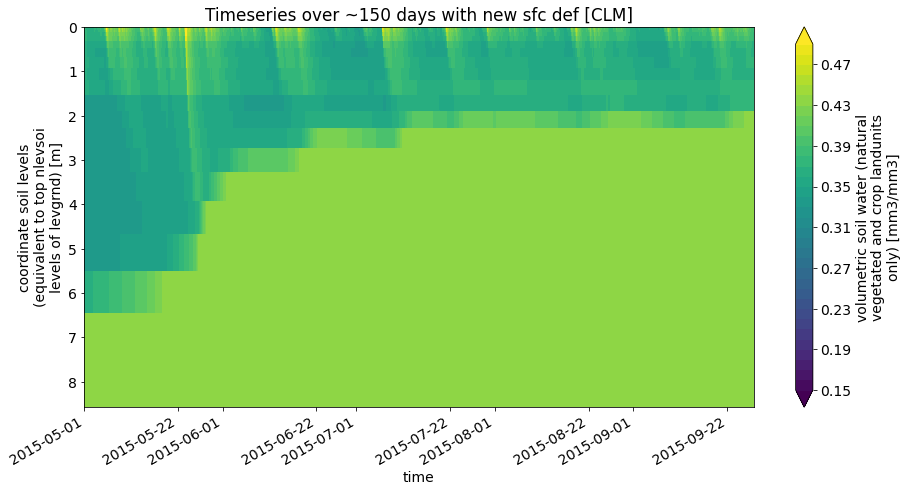

In [39]:
varPlot = 'H2OSOI'

fig,axs = plt.subplots(1,1, figsize=(15,7))

caseCLM_h0_rnd2[varPlot].plot(x='time',levels=np.arange(0.15,0.5,0.01),extend='both')
plt.title('Timeseries over ~150 days with new sfc def [CLM]')
plt.rcParams.update({'font.size': 14})
axs.invert_yaxis()


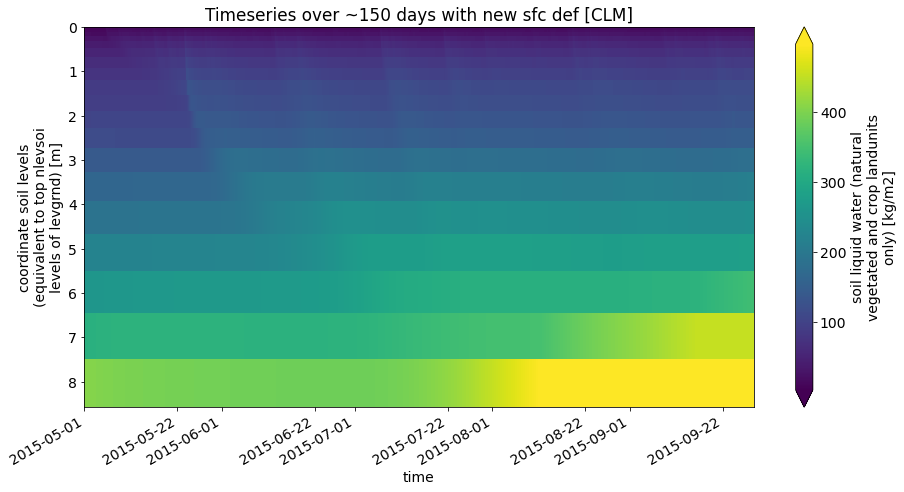

In [42]:
varPlot = 'SOILLIQ'

fig,axs = plt.subplots(1,1, figsize=(15,7))

caseCLM_h0_rnd1[varPlot].plot(x='time',extend='both')
plt.title('Timeseries over ~150 days with new sfc def [CLM]')
plt.rcParams.update({'font.size': 14})
axs.invert_yaxis()


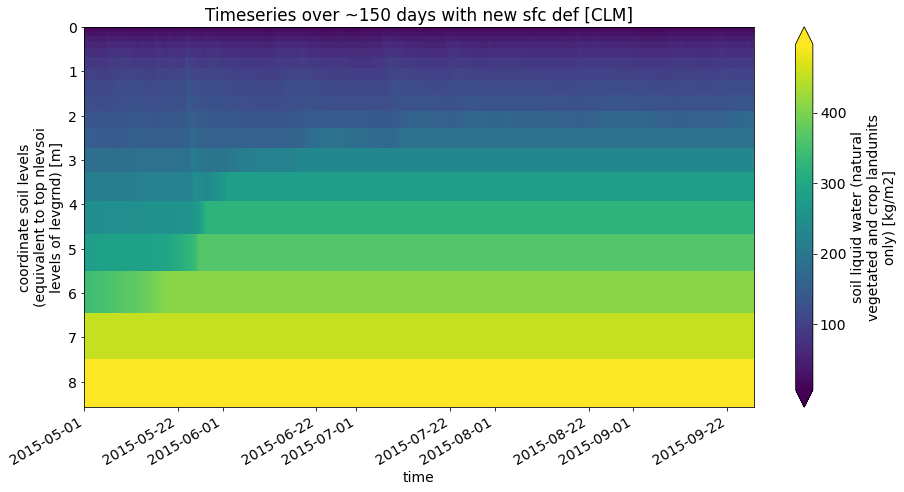

In [43]:
varPlot = 'SOILLIQ'

fig,axs = plt.subplots(1,1, figsize=(15,7))

caseCLM_h0_rnd2[varPlot].plot(x='time',extend='both')
plt.title('Timeseries over ~150 days with new sfc def [CLM]')
plt.rcParams.update({'font.size': 14})
axs.invert_yaxis()
